In [1]:
# uni_D83AE5_uni (Baseline)
#   {"Logloss": 0.025278024648978815, "ROCAUC": 0.980661482784129}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import gamma, kstest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_auc_score, 
    roc_curve, 
    auc
)
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')  # Use this line to suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

training_data = pd.read_csv('training_data.csv')
training_data = training_data[training_data['BORROWER_ID'] != 'xNullx']
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_submission_example = pd.read_csv('data_submission_example.csv')

In [2]:
training_data.fillna(0, inplace=True)
for col in training_data.columns:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='ignore')
    except:
        continue
training_data['TARGET_EVENT_BINARY'] = np.where(training_data['TARGET_EVENT'] == 'K', 1, 0)

In [3]:
training_data['TARGET_EVENT_E'] = np.where(training_data['TARGET_EVENT'] == 'E', 1, 0)

In [4]:
training_data['TARGET_EVENT_BINARY'].value_counts()

TARGET_EVENT_BINARY
0    1590792
1      10871
Name: count, dtype: int64

In [5]:
lognormal_variables = [
    'CONTRACT_CREDIT_LOSS', 'CONTRACT_DEPT_SERVICE_TO_INCOME',
    'CONTRACT_INCOME', 'CONTRACT_INSTALMENT_AMOUNT', 'CONTRACT_INSTALMENT_AMOUNT_2',
    'CONTRACT_LOAN_AMOUNT', 'CONTRACT_MARKET_VALUE', 'CONTRACT_MORTGAGE_LENDING_VALUE', 
    'CONTRACT_LGD', 'CONTRACT_INCOME'
]
date_variables = ['CONTRACT_DATE_OF_LOAN_AGREEMENT', 'CONTRACT_MATURITY_DATE']

In [6]:
training_data['TARGET_EVENT_DAY'].replace(0.0, np.nan, inplace=True)
training_data['TARGET_EVENT_DAY_JULIAN'] = pd.to_datetime(training_data['TARGET_EVENT_DAY'], origin='julian', unit='D', errors='coerce')
training_data['TARGET_EVENT_DAY_DATETIME'] = pd.to_datetime(training_data['TARGET_EVENT_DAY_JULIAN'],  errors='coerce')

training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'], origin='julian', unit='D')
training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'],)

training_data['CONTRACT_MATURITY_DATE_JULIAN'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE'], origin='julian', unit='D')
training_data['CONTRACT_MATURITY_DATE_DATETIME'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE_JULIAN'])

In [7]:
training_data['DAY_DIFF'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['DAYS_TO_END'] = (pd.Timestamp("2020-01-01")- training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['YEARS_TO_END'] = training_data['DAYS_TO_END'] / 365
training_data['DAYS_TO_2018'] = (pd.Timestamp("2018-01-01")- training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['YEARS_TO_2018'] = training_data['DAYS_TO_2018'] / 365
training_data['TIME_TO_MATURITY_DAYS'] = (training_data['CONTRACT_MATURITY_DATE']-training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'])
training_data['2020_OR_MATURITY'] = np.minimum(training_data['TIME_TO_MATURITY_DAYS'], training_data['DAYS_TO_END'])
training_data['2020_OR_MATURITY_YEARS'] = training_data['2020_OR_MATURITY'] / 365

In [8]:
def create_binary_target_column(dataframe, column_name, event, day_diff_upper_limit):
    dataframe[column_name] = np.where(
        (dataframe['TARGET_EVENT'] == event) & 
        (dataframe['DAY_DIFF'] <= day_diff_upper_limit) & 
        (dataframe['DAY_DIFF'] >= 0), 
        1, 
        0
    )

timeframes = {
    'TARGET_EVENT_BINARY_2Y': 730,
    'TARGET_EVENT_BINARY_1Y': 365,
    'TARGET_EVENT_BINARY_6M': 365//2,
}

for column_name, days in timeframes.items():
    create_binary_target_column(training_data, column_name, 'K', days)


# target_event_binary_columns = []
# for i in range(6):
#     start_day = 273 + i * 30
#     column_header = 'TARGET_EVENT_BINARY_' + str(start_day) + 'D'
#     training_data[column_header] = np.where(
#         (training_data['TARGET_EVENT'] == 'K') & 
#         (training_data['DAY_DIFF'] <= start_day) & 
#         (training_data['DAY_DIFF'] >= 0), 
#         1, 
#         0
#     )
#     target_event_binary_columns.append(column_header)

training_data.drop('DAY_DIFF', axis=1, inplace=True)

In [9]:
print(training_data['TARGET_EVENT_BINARY'].value_counts())
print(training_data['TARGET_EVENT_BINARY_2Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_1Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_6M'].value_counts())

TARGET_EVENT_BINARY
0    1590792
1      10871
Name: count, dtype: int64
TARGET_EVENT_BINARY_2Y
0    1591751
1       9912
Name: count, dtype: int64
TARGET_EVENT_BINARY_1Y
0    1596927
1       4736
Name: count, dtype: int64
TARGET_EVENT_BINARY_6M
0    1601267
1        396
Name: count, dtype: int64


In [10]:
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
excluded_keywords = ['TARGET', 'event', 'binary', 'DATE', 'DAYS', 'YEARS', 'MATURITY', 'DAY']

X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
y_column = 'TARGET_EVENT_BINARY_2Y' 
X_columns

['CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_CREDIT_LOSS',
 'CONTRACT_CURRENCY',
 'CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_INSTALMENT_AMOUNT_2',
 'CONTRACT_INTEREST_PERIOD',
 'CONTRACT_INTEREST_RATE',
 'CONTRACT_LGD',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_LOAN_CONTRACT_TYPE',
 'CONTRACT_LOAN_TO_VALUE_RATIO',
 'CONTRACT_MARKET_VALUE',
 'CONTRACT_MORTGAGE_LENDING_VALUE',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_REFINANCED',
 'CONTRACT_RISK_WEIGHTED_ASSETS',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_BIRTH_YEAR',
 'BORROWER_CITIZENSHIP',
 'BORROWER_COUNTRY',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT']

In [11]:
import numpy as np
import numpy_financial as npf
import pandas as pd

def calculate_monthly_payment(row):
    annual_interest_rate = row['CONTRACT_INTEREST_RATE'] / 100  # Convert percentage to decimal
    monthly_interest_rate = annual_interest_rate / 12
    term_in_months = ((pd.to_datetime(row['CONTRACT_MATURITY_DATE_DATETIME'], format='%d/%m/%Y') - 
                       pd.to_datetime(row['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'], format='%d/%m/%Y'))).days/30
    principal = row['CONTRACT_LOAN_AMOUNT']
    monthly_payment = npf.pmt(monthly_interest_rate, term_in_months, -principal)
    return monthly_payment
# ALL THE EXTRA :
# training_data['MONTHLY_PAYMENT'] = training_data.apply(calculate_monthly_payment, axis=1)
# training_data['MONTHLY_PAYMENT'] = training_data['MONTHLY_PAYMENT'].apply(lambda x: 0 if not np.isfinite(x) else x)
# X_columns.extend(['MONTHLY_PAYMENT'])
# lognormal_variables.extend(['MONTHLY_PAYMENT'])
# X_columns.append('TIME_TO_MATURITY_DAYS')

In [12]:
loan_type_dummies = pd.get_dummies(training_data['CONTRACT_LOAN_TYPE'], prefix='LOAN_TYPE', drop_first=True)
frequency_type_dummies = pd.get_dummies(training_data['CONTRACT_FREQUENCY_TYPE'], prefix='FREQ_TYPE', drop_first=True)
interest_type_dummies = pd.get_dummies(training_data['CONTRACT_TYPE_OF_INTEREST_REPAYMENT'], prefix='INTEREST_TYPE', drop_first=True)
mortgage_type_dummies =  pd.get_dummies(training_data['CONTRACT_MORTGAGE_TYPE'], prefix='MORTGAGE_TYPE', drop_first=True)

training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies,interest_type_dummies,mortgage_type_dummies ], axis=1)

X_columns.extend(loan_type_dummies.columns)
X_columns.extend(frequency_type_dummies.columns)
X_columns.extend(interest_type_dummies.columns)
X_columns.extend(mortgage_type_dummies.columns)

In [13]:
training_data['BORROWER_LOAN_COUNT'] = training_data.groupby('BORROWER_ID')['BORROWER_ID'].transform('count')
training_data['LOAN_BORROWER_COUNT'] = training_data.groupby('CONTRACT_ID')['CONTRACT_ID'].transform('count')
training_data['TOTAL_LOAN_AMOUNT'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_1'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_2'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT_2'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT'] = training_data['TOTAL_INSTALLMENT_AMOUNT_1'] + training_data['TOTAL_INSTALLMENT_AMOUNT_2']

X_columns.extend(['BORROWER_LOAN_COUNT', 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT','LOAN_BORROWER_COUNT'])
lognormal_variables.extend([ 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])

In [14]:
threshold = 0.95
correlation_matrix = training_data[X_columns].corr()
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_set.add(colname)

X_columns = [col for col in X_columns if col not in highly_correlated_set]
print('Variables removed:', highly_correlated_set)

Variables removed: {'FREQ_TYPE_2f88e16c', 'CONTRACT_REFINANCED', 'BORROWER_COUNTRY'}


In [15]:
def default_percentage_generator_2016(df, percentage, target):
    df_copy = df.copy()
    df_filtered = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    df_mean = df_filtered[target].mean()
    print(f"Mean in year {df_mean}")
    df_defautled = df_filtered[target].sum()
    df_not_defaulted = len(df_filtered) - df_defautled

    required_val = (df_defautled - percentage * len(df_filtered))/(percentage - 1)
    
    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==1] 
    print(len(df_filtered_after))
    print(required_val)
    required_val = min(int(required_val) ,len(df_filtered_after))
    df_filtered_after = df_filtered_after.sample(n=int(required_val),random_state=42).reset_index(drop=True)

    df_filtered = pd.concat([df_filtered, df_filtered_after])

    return df_filtered

def default_percentage_generator_2016_maximal(df, percentage, target):
    df_copy = df.copy()

    defaulted = df_copy[(df_copy[target]==1) & (df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2018-01-01')]
    total_needed = len(defaulted) / percentage * 100 - len(defaulted)


    # print(len(defaulted))
    # print(total_needed)

    df_filtered_2016 = df_copy[(df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01')& (df_copy[target]==0)]
    # print(len(df_filtered_2016))
    # print(total_needed)
    max_needed = min(total_needed,len(df_filtered_2016))
    df_filtered_2016 = df_filtered_2016.sample(n=int(max_needed),random_state=42).reset_index(drop=True)

    extra_needed = total_needed - len(df_filtered_2016)

    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==0]
    df_filtered_after = df_filtered_after.sample(n=int(extra_needed),random_state=42).reset_index(drop=True)


    df_filtered = pd.concat([df_filtered_2016, df_filtered_after,defaulted])

    return df_filtered

# default_percentage_generator_2016_maximal(training_data, 1.48, 'TARGET_EVENT_BINARY')['TARGET_EVENT_BINARY'].mean()


In [16]:
def calculate_probabilities(data, column, time_factor):
    lambdas = -np.log(1 - data[column]) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y
def calculate_probabilities_vec(data, time_factor):
    lambdas = -np.log(1 - data) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y


In [17]:
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE


def train_and_predict_two_halves(df, variables, target, model=LogisticRegression(), scaler=StandardScaler(), augment_distribution=False,calibrate=False,augment_distribution_percentage = 1.48, unique_loans=False,should_smote =False,maximal_sample=False):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    if augment_distribution and not maximal_sample:
        df_filtered = default_percentage_generator_2016(df, augment_distribution_percentage/100, target)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    
    if maximal_sample:
        df_filtered = default_percentage_generator_2016_maximal(df, augment_distribution_percentage, target)
        print(df_filtered[target].mean())

    if unique_loans:
        df_filtered = df_filtered.drop_duplicates(subset=['CONTRACT_ID'])

    
    X_scaled = scaler.fit_transform(df[variables])
    X_filtered = scaler.transform(df_filtered[variables])

    y = df[target] 
    y_filtered = df_filtered[target] 
    if should_smote:
        smote = SMOTE(random_state=42)
        X_filtered, y_filtered = smote.fit_resample(X_filtered, y_filtered)

    if calibrate:
        model = CalibratedClassifierCV(base_estimator=model, method='isotonic', )

    model.fit(X_filtered, y_filtered)
    

    print("Logloss:")
    print(log_loss(y_filtered, model.predict_proba(X_filtered)))
    proba = model.predict_proba(X_scaled)[:, 1]
    # Additional code for ROC AUC score
    roc_auc = roc_auc_score(y_filtered, model.predict_proba(X_filtered)[:,1])
    print("ROC AUC Score:", roc_auc)

    return proba


In [18]:
def significant_features(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    X_scaled = scaler.fit_transform(df[variables])

    X = sm.add_constant(pd.DataFrame(X_scaled, columns=variables))
    y = df[target]
    model = sm.Logit(y, X).fit()
    print(model.summary())
    p_values = model.pvalues
    non_significant_vars = p_values[p_values > 0.05].index.tolist()

    return model, non_significant_vars

In [156]:
def combined_probability(s):
    if len(s) == 2:
        p_a, p_b = s.values
        return p_a + p_b - p_a * p_b #- (-3.2357827075016176e-05)
    else:
        return 1 - np.prod(1 - s.values)

def create_submission_file(df_preds, target, example, filename='submission.csv', testing=False):
    # Filter the data to only include BORROWER_IDs that are in the submission example
    df_preds.loc[df_preds['TARGET_EVENT'] == 'E', target] = 0

    print("Logloss:")
    print(log_loss(df_preds['TARGET_EVENT_BINARY'], df_preds[target]))

    filtered_training_data = df_preds[df_preds['BORROWER_ID'].isin(example['BORROWER_ID'])]

    # Print warning if the row count is off
    if not testing and len(filtered_training_data) != 1564601:
        print('WARNING: The filtered data does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
    # Group by BORROWER_ID and calculate the combined probability

    #######################x########################
    #CUTTING TAILS DID NOT SEEM TO WORK
    #######################x########################
    # filtered_training_data = cut_exponential_tails(filtered_training_data, target)
    grouped_data = filtered_training_data.groupby('BORROWER_ID')[target].apply(combined_probability).reset_index()

    # Create the submission DataFrame
    df_submission = pd.DataFrame()
    df_submission['BORROWER_ID'] = grouped_data['BORROWER_ID']
    df_submission['PRED'] = grouped_data[target]
    print('Before centering:')
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    print('Centering probabilities...')
    # Center the probabilities around 1.48%
    desired_mean = 0.0148  # 1.48% as a decimal
    # while (df_submission['PRED'].max() > 1 or df_submission['PRED'].min() < 0 or abs(df_submission['PRED'].mean() -0.0148) > 0.0005):
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    #     df_submission['PRED'] = df_submission['PRED'].clip(lower=0, upper=1)
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    #     current_mean = df_submission['PRED'].mean()
    #     adjustment_factor = desired_mean  - current_mean
    #     df_submission['PRED'] += adjustment_factor
    initial_guess = 2
    probas_unscaled = df_submission['PRED'].values
    new_proba = probas_unscaled.copy()
    while abs(new_proba.mean() - desired_mean) > 0.00001:
        
        new_proba = calculate_probabilities_vec(probas_unscaled, initial_guess)
        error = new_proba.mean() - desired_mean
        if error > 0:
            initial_guess += 0.001
        else:
            initial_guess -= 0.001
        print(error, initial_guess)
    df_submission['PRED'] = new_proba
        
        
    
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    # Save the submission file
    if  not testing and filename is not None:
        df_submission.to_csv(filename, index=False)
    print(f'Saved file: {filename}')
    # if abs(df_submission['PRED'].mean() -0.0148) > 0.0005:
    #    raise ValueError('WARNING: mean is bad')
        
    # Print warning if the row count is off
    if not testing and len(df_submission) != 1117674:
        print('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        
    return df_submission


In [20]:
def test_model_2y_1y(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression()):
    df = df.copy()
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2017-01-01')

    # Mask for rows with CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN between start_date and end_date
    mask_date_range = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] >= start_date) & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] <= end_date)

    df = df[mask_date_range]

    probs = train_and_predict_two_halves(
        df, 
        variables, 
        target, 
        model1=model1,
        model2=model2,
    )
    df['2Y-1Y-PROBS'] = probs
    
    test_data = pd.read_csv('./data/1y-test.csv')


    df_submission = create_submission_file(df, '2Y-1Y-PROBS', test_data, filename=None, testing=True)

    merged_df = pd.merge(test_data, df_submission, on='BORROWER_ID')
    true_labels = merged_df['TARGET_EVENT_BINARY_1Y']
    predicted_probs = merged_df['PRED']
    logloss = log_loss(true_labels, predicted_probs)

    print(f'Log loss: {logloss}')
        
    return logloss

In [ ]:
def scale_yearly_proba(data, proba, targets =[ 0.0051, 0.0098, 0.0185], logging=False):
    data = data.copy()
    probs = data[proba]
    starter_scales=[2.8, 1.2, 0.75]
    new_proba = np.zeros(len(data))
    mask_2016 = (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01') & (data['TARGET_EVENT_BINARY'] != 1)
    mask_2017 = (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') & (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')& (data['TARGET_EVENT_BINARY'] != 1)
    mask_2018 = (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01') & (data['TARGET_EVENT_BINARY'] != 1)

    proba_2016 = probs
    proba_2017 = probs
    proba_2018 = probs
    if logging:
        print("Before scaling:")
        print(proba_2016[mask_2016].mean(), proba_2017[mask_2017].mean(), proba_2018[mask_2018].mean())
        print(probs.mean())
    calib_2016 = True
    calib_2017 = True
    calib_2018 = True

    while calib_2016 or calib_2017 or calib_2018:    
        proba_2016 = probs
        proba_2017 = probs
        proba_2018 = probs
        proba_2016 = calculate_probabilities_vec(proba_2016, starter_scales[0])
        proba_2017 = calculate_probabilities_vec(proba_2017, starter_scales[1])
        proba_2018 = calculate_probabilities_vec(proba_2018, starter_scales[2])
        
        new_proba[mask_2016] = proba_2016[mask_2016]
        new_proba[mask_2017] = proba_2017[mask_2017]
        new_proba[mask_2018] = proba_2018[mask_2018]
        if logging:
            print('Adter scaling:')
            print(proba_2016[mask_2016].mean(), proba_2017[mask_2017].mean(), proba_2018[mask_2018].mean())
            print(new_proba.mean())

        mean_2016 = proba_2016[mask_2016].mean()
        mean_2017 = proba_2017[mask_2017].mean()
        mean_2018 = proba_2018[mask_2018].mean()

        diff_2016 = mean_2016 - targets[0]
        diff_2017 = mean_2017 - targets[1]
        diff_2018 = mean_2018 - targets[2]
        if diff_2016 > 0.0001:
            starter_scales[0] += 0.01
        elif diff_2016 < -0.0001:
            starter_scales[0] -= 0.01
        else:
            calib_2016 = False
        if diff_2017 > 0.0001:
            starter_scales[1] += 0.01
        elif diff_2017 < -0.0001:
            starter_scales[1] -= 0.01
        else:
            calib_2017 = False
        if diff_2018 > 0.0001:
            starter_scales[2] += 0.01
        elif diff_2018 < -0.0001:
            starter_scales[2] -= 0.01
        else:
            calib_2018 = False
    return new_proba
    

In [21]:
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014855
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601611
# Method:                               MLE   Df Model:                           51
# Date:                    Wed, 08 Nov 2023   Pseudo R-squ.:                  0.6053
# Time:                            17:03:09   Log-Likelihood:                -23792.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000

#  No dummies and feature engineering:
# Optimization terminated successfully.
#          Current function value: 0.017321
#          Iterations 13
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601638
# Method:                               MLE   Df Model:                           24
# Date:                    Wed, 08 Nov 2023   Pseudo R-squ.:                  0.5398
# Time:                            20:38:24   Log-Likelihood:                -27743.
# converged:                           True   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
# Two more variables added: LOAN_TYPE, FREQ_TYPE, MORGTAGE_TYPE, INTEREST_TYPE
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014613
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601589
# Method:                               MLE   Df Model:                           73
# Date:                    Thu, 09 Nov 2023   Pseudo R-squ.:                  0.6118
# Time:                            18:28:24   Log-Likelihood:                -23405.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
# Adding monthly to LOAN_TYPE, FREQ_TYPE, MORGTAGE_TYPE, INTEREST_TYPE
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014232
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601584
# Method:                               MLE   Df Model:                           78
# Date:                    Thu, 09 Nov 2023   Pseudo R-squ.:                  0.6219
# Time:                            18:35:37   Log-Likelihood:                -22795.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
#  ADDING TIME TO MATURITY in days
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014143
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601586
# Method:                               MLE   Df Model:                           76
# Date:                    Mon, 13 Nov 2023   Pseudo R-squ.:                  0.6242
# Time:                            17:00:42   Log-Likelihood:                -22653.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000



In [324]:
X_copy = X_columns.copy()
X_copy.remove('CONTRACT_CREDIT_INTERMEDIARY')
X_copy.remove('BORROWER_COUNTY')
X_copy.remove('CONTRACT_TYPE_OF_INTEREST_REPAYMENT')
X_copy.remove('CONTRACT_MORTGAGE_TYPE')
X_copy.remove('BORROWER_TYPE_OF_SETTLEMENT')
X_copy.remove('CONTRACT_LOAN_AMOUNT')
X_copy.remove('CONTRACT_INSTALMENT_AMOUNT')


In [ ]:
model, non_significant_vars = significant_features(training_data, X_columns, y_column,LogisticRegression())

         Current function value: 0.014609
         Iterations: 35
                             Logit Regression Results                             
Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
Model:                              Logit   Df Residuals:                  1601588
Method:                               MLE   Df Model:                           74
Date:                    Tue, 14 Nov 2023   Pseudo R-squ.:                  0.6119
Time:                            12:08:19   Log-Likelihood:                -23398.
converged:                          False   LL-Null:                       -60284.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -10.3999   2.84e+05  -3.

In [ ]:
non_significant_vars

['const',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT',
 'LOAN_TYPE_1f951336',
 'LOAN_TYPE_2f88e16c',
 'LOAN_TYPE_47693941',
 'LOAN_TYPE_5a06241e',
 'LOAN_TYPE_694cbaee',
 'LOAN_TYPE_69f70539',
 'LOAN_TYPE_7e2065f4',
 'LOAN_TYPE_83910425',
 'LOAN_TYPE_8fe006f1',
 'LOAN_TYPE_955ae3ef',
 'LOAN_TYPE_95c4f8fb',
 'LOAN_TYPE_b503a0de',
 'LOAN_TYPE_cde77491',
 'LOAN_TYPE_cf07c2dd',
 'LOAN_TYPE_d3aaffde',
 'LOAN_TYPE_eab72d7a',
 'LOAN_TYPE_f792971b',
 'FREQ_TYPE_89efd382',
 'FREQ_TYPE_bd092d5a',
 'INTEREST_TYPE_100001.0',
 'INTEREST_TYPE_100002.0',
 'INTEREST_TYPE_100003.0',
 'INTEREST_TYPE_100004.0',
 'INTEREST_TYPE_110001.0',
 'INTEREST_TYPE_140001.0',
 'INTEREST_TYPE_140002.0',
 'INTEREST_TYPE_140003.0',
 'MORTGAGE_TYPE_1.0',
 'MORTGAGE_TYPE_3.0',
 'MORTGAGE_TYPE_4.0',
 'MORTGAGE_TYPE_5.0',
 'MORTGAGE_TYPE_6.0',
 'MORTGAGE_TYPE_7.0',
 'MORTGAGE_TYPE_8.0',
 'MORTGA

In [22]:
# X_columns.remove('CONTRACT_CREDIT_INTERMEDIARY')
# X_columns.remove('BORROWER_COUNTY')
# Assuming you have a pandas DataFrame named training_data
# unique_training_data = training_data.drop_duplicates(subset='CONTRACT_ID', keep='first')


In [22]:
# 0.006785876080349979
# Before centering:
# 0.9978858840423693 8.548717289613705e-15 0.006063585227926563
# Centering probabilities...
# 1.0 0.008736424229876956 0.01479999999999999
# One extra dummy
# Logloss: 0.02502985804399272
# Zero extra dummy
# Logloss: 0.025941091599465484
# All dummies
# Logloss: 0.024974156733831323
# Adding calib (isotonic)
# Logloss: 0.02385418586559387
predicted_probs = 'LOGISTIC_REG'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model=LogisticRegression(max_iter=400, random_state=42,solver='lbfgs'),
    augment_distribution=True,
    augment_distribution_percentage=1.48,
    calibrate=True,
    unique_loans=False,
    should_smote=False,
    maximal_sample=False,
)
training_data[predicted_probs] = probs
print(probs.mean())
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'LOGISTIC_REG'] = 0

Mean in year 0.011345816067598232
5206
1750.5931790499392
Logloss:
0.02385418586559387
ROC AUC Score: 0.988458183190618
0.014301368577331398


In [141]:
new_proba = scale_yearly_proba(training_data, 'LOGISTIC_REG')
print(new_proba.mean())
training_data['YEAR_SCALED_PROBA'] = new_proba

0.011471666481450598


In [ ]:
submission = create_submission_file(training_data, 'YEAR_SCALED_PROBA', data_submission_example, filename='./predictions/best-model-so-far.csv')

In [31]:
# Logloss:
# 0.010851681705608482
# ROC AUC Score: 0.9988352689711549
predicted_probs = 'XGB'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model=xgb.XGBClassifier(max_depth=2,n_estimators=70, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    augment_distribution=True,
    augment_distribution_percentage=1.48,
    calibrate=True,
)
training_data[predicted_probs] = probs
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'XGB'] = 0

Mean in year 0.011345816067598232
5206
1750.5931790499392
Logloss:
0.01727067871139171
ROC AUC Score: 0.996301268288478
0.012003122193147064


In [144]:
training_data['ENSEMBLE'] = 0.6*training_data['XGB'] + 0.4*training_data['LOGISTIC_REG']
new_proba = scale_yearly_proba(training_data, 'ENSEMBLE')
training_data['XGB_YEAR_SCALED_PROBA'] = new_proba
print(new_proba.mean())

0.01138851377537405


In [114]:
submission = create_submission_file(training_data, 'XGB_YEAR_SCALED_PROBA', data_submission_example, filename='./predictions/best-model-so-far.csv')

Before centering:
0.9999999999910126 5.139958767053088e-06 0.01473769332470362
Centering probabilities...
-6.230667529638113e-05 1.999
-5.794462093077109e-05 1.9980000000000002
-5.3579653588936224e-05 1.9970000000000003
-4.921176998388781e-05 1.9960000000000004
-4.484096682318313e-05 1.9950000000000006
-4.046724080898449e-05 1.9940000000000007
-3.609058863795166e-05 1.9930000000000008
-3.1711007001299085e-05 1.9920000000000009
-2.7328492584768188e-05 1.991000000000001
-2.2943042068613445e-05 1.990000000000001
-1.855465212756771e-05 1.9890000000000012
-1.4163319430866503e-05 1.9880000000000013
-9.769040642220242e-06 1.9870000000000014
0.9999999999922918 5.170984594848882e-06 0.01479023095935778
Saved file: ./predictions/best-model-so-far.csv


In [170]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

# Logloss:
# 0.02484109588442129 RF 200-3
predicted_probs = 'NN'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model= RandomForestClassifier(n_estimators=200, max_depth=4, random_state=42, min_samples_leaf=10   ),
    augment_distribution=True,
    augment_distribution_percentage=1.48,
    calibrate=True,
)
training_data[predicted_probs] = probs
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'NN'] = 0

Mean in year 0.011345816067598232
5206
1750.5931790499392
Logloss:
0.023534501248296504
ROC AUC Score: 0.9921772155542318
0.01370514714527384


In [171]:
training_data['ENSEMBLE_NN'] = 0.9*training_data['ENSEMBLE']+ 0.1*training_data['NN']

In [172]:
new_proba = scale_yearly_proba(training_data, 'ENSEMBLE_NN')
print(new_proba.mean())

0.011417122716120776


In [173]:
training_data['NN_LOG_XGB'] = new_proba

In [174]:
# Logloss:
# 0.2627792536515289: 
submission = create_submission_file(training_data, 'NN_LOG_XGB', data_submission_example, filename='./predictions/nn-xgb-log.csv')

Logloss:
0.26376104122972716
Before centering:
0.9999999999957813 6.513717506151373e-06 0.014741305818409487
Centering probabilities...
-5.869418159051322e-05 1.999
-5.422131333339235e-05 1.9980000000000002
-4.97454049269222e-05 1.9970000000000003
-4.526645290427872e-05 1.9960000000000004
-4.078445379289419e-05 1.9950000000000006
-3.629940411443294e-05 1.9940000000000007
-3.181130038474797e-05 1.9930000000000008
-2.7320139113870545e-05 1.9920000000000009
-2.282591680607786e-05 1.991000000000001
-1.8328629959757717e-05 1.990000000000001
-1.3828275067469253e-05 1.9890000000000012
-9.324848615939463e-06 1.9880000000000013
0.9999999999963501 6.549740964145734e-06 0.014790675151384061
Saved file: ./predictions/nn-xgb-log.csv


In [175]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

# Logloss:
# 0.02484109588442129 RF 200-3
predicted_probs = 'LGBM'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model= LGBMClassifier(n_estimators=100, max_depth=3,boosting_type="dart", random_state=42),
    augment_distribution=True,
    augment_distribution_percentage=1.48,
    calibrate=True,
)
training_data[predicted_probs] = probs
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'LGBM'] = 0

training_data['ENSEMBLE_LGBM'] = 0.9*training_data['ENSEMBLE_NN']+ 0.1*training_data['LGBM']

Mean in year 0.011345816067598232
5206
1750.5931790499392
[LightGBM] [Info] Number of positive: 5932, number of negative: 394910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4328
[LightGBM] [Info] Number of data points in the train set: 400842, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014799 -> initscore=-4.198296
[LightGBM] [Info] Start training from score -4.198296
[LightGBM] [Info] Number of positive: 5932, number of negative: 394910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4330
[LightGBM] [Info] Number of data points in the train

In [176]:
new_proba = scale_yearly_proba(training_data, 'ENSEMBLE_LGBM')
print(new_proba.mean())
training_data['NN_LOG_XGB_LGBM'] = new_proba

0.01138646256633836


In [177]:
# Logloss:
# 0.2627792536515289: 
submission = create_submission_file(training_data, 'NN_LOG_XGB_LGBM', data_submission_example, filename='./predictions/nn-xgb-log-lgbm.csv')

Logloss:
0.26384619799992565


In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

# Logloss:
# 0.02484109588442129 RF 200-3
predicted_probs = 'SVC'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model= BaggingClassifier(SVC(kernel='linear', probability=True), max_samples=1.0 / 100, n_estimators=10),
    augment_distribution=True,
    augment_distribution_percentage=1.48,
    calibrate=True,
)
training_data[predicted_probs] = probs
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'SVC'] = 0

training_data['ENSEMBLE_SVC'] = 0.9*training_data['ENSEMBLE_LGBM']+ 0.1*training_data['SVC']

Mean in year 0.011345816067598232
5206
1750.5931790499392
Logloss:
0.030210098907790396
ROC AUC Score: 0.9828321631874859
0.01576554629812938


In [ ]:
new_proba = scale_yearly_proba(training_data, 'ENSEMBLE_SVC')
print(new_proba.mean())
training_data['NN_LOG_XGB_LGBM_SVC'] = new_proba

In [ ]:
# Logloss:
# 0.2627792536515289: 
submission = create_submission_file(training_data, 'NN_LOG_XGB_LGBM_SVC', data_submission_example, filename='./predictions/nn-xgb-log-lgbm-svc.csv')

In [69]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import numpy as np

# Other necessary imports, like pandas, if you're using a DataFrame

def train_and_evaluate(df, variables, target, model=LogisticRegression(), scaler=StandardScaler(), cv_folds=5, augment_distribution=False):
    # Your lognormal_variables transformation code remains the same
    if lognormal_variables is not None:
        df = df.copy()
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    # Split the data before the given date for training 
    if augment_distribution:
        df_filtered = default_percentage_generator_2016(df, 1.48/100, target)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    X_filtered = df_filtered[variables]
    y_filtered = df_filtered[target]
    
    # Scale the filtered features
    X_filtered_scaled = scaler.fit_transform(X_filtered)
    
    # Perform cross-validation and fit the model
    cv_scores = cross_val_score(model, X_filtered_scaled, y_filtered, cv=cv_folds, scoring='neg_log_loss')
    
    print(f"CV Log Loss Scores: {-cv_scores}")
    print(f"Mean CV Log Loss: {-np.mean(cv_scores)}")
    
    # Now fit the model to the entire dataset
    model.fit(X_filtered_scaled, y_filtered)
    
    # Scale the entire dataset to predict probabilities for all records
    X_scaled = scaler.transform(df[variables])
    
    # Predict probabilities using the trained model
    proba = model.predict_proba(X_scaled)[:, 1]

    print("Logloss:")
    print(log_loss(y_filtered, model.predict_proba(X_filtered_scaled)))
    # Calculate log loss on the full dataset
    full_log_loss = log_loss(df[target], proba)

    print(f"Full Dataset Log Loss: {full_log_loss}")

    return proba, cv_scores, full_log_loss

# You might call the function like this
# probabilities, cv_scores, full_log_loss = train_and_evaluate(df, variables, target)



In [75]:
# Logloss xgb :
# 0.016317211616370328
# Logloss logistic regression:
# 0.02385418586559387
predicted_probs = 'XGBOOST'
probs, _, _ = train_and_evaluate(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model=xgb.XGBClassifier(max_depth=3, reg_lambda=1, n_estimators=60, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    augment_distribution=True
)
training_data[predicted_probs] = probs
print(probs.mean())


Mean in year 0.011345816067598232
5206
1750.5931790499392
CV Log Loss Scores: [0.01667644 0.01774652 0.01745249 0.01623867 0.01555608]
Mean CV Log Loss: 0.016734038342269535
Logloss:
0.015519565880210438
Full Dataset Log Loss: 0.014339806792168251
0.011670229


In [ ]:
probs.std()

0.08458669

In [ ]:
magic_number = 1.6
experiment_probs = calculate_probabilities(training_data, 'XGBOOST', magic_number)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())


0.012484113731198196 0.9992862747843598 1.490116185998147e-07 0.0915481464181552


In [ ]:
training_data['EXPERIMENT_PROBS_XGB'] = experiment_probs
submission_exp = create_submission_file(training_data, 'EXPERIMENT_PROBS_XGB', data_submission_example, filename='./predictions/xgb-prediction-with-time-param-0-585.csv')

Before centering:
0.9999999999999525 1.490116185998147e-07 0.008892199973826601
Centering probabilities...
-0.0059078000261734 1.999
-0.005905262074956378 1.9980000000000002
-0.005902722483183378 1.9970000000000003
-0.005900181249059751 1.9960000000000004
-0.005897638370787961 1.9950000000000006
-0.005895093846567579 1.9940000000000007
-0.005892547674595324 1.9930000000000008
-0.005889999853064994 1.9920000000000009
-0.005887450380167499 1.991000000000001
-0.005884899254090836 1.990000000000001
-0.005882346473020113 1.9890000000000012
-0.005879792035137487 1.9880000000000013
-0.005877235938622223 1.9870000000000014
-0.0058746781816506385 1.9860000000000015
-0.005872118762396133 1.9850000000000017
-0.005869557679029141 1.9840000000000018
-0.005866994929717161 1.9830000000000019
-0.005864430512624728 1.982000000000002
-0.005861864425913443 1.981000000000002
-0.005859296667741909 1.9800000000000022
-0.0058567272362657595 1.9790000000000023
-0.005854156129637659 1.9780000000000024
-0.00585

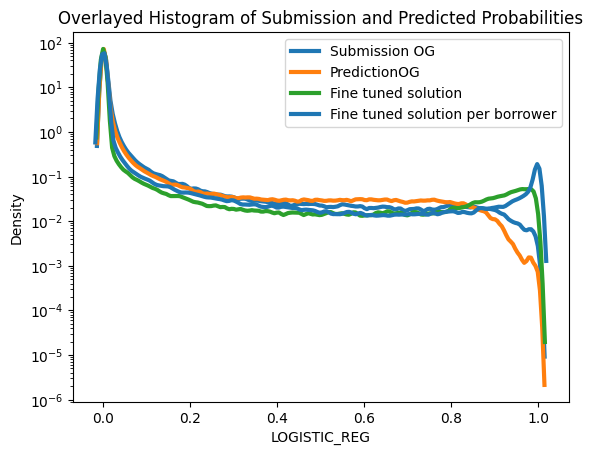

In [ ]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
sns.kdeplot(experiment_probs, label='Fine tuned solution', lw=3, alpha=1)
sns.kdeplot(submission_exp, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [ ]:
condition = (submission_exp['PRED'] > 0.9999)# | (submission_exp['PRED'] < 0.01)
ensemble_submission = submission.copy()
ensemble_submission.loc[condition,'PRED'] = submission_exp.loc[condition,'PRED']

In [ ]:
condition.sum()

902

In [ ]:
ensemble_submission['PRED'].mean()  

0.01494954796107231

In [ ]:
calculate_probabilities_vec(ensemble_submission['PRED'].values, 2.029).mean()

0.014804265269186677

In [ ]:
ensemble_submission['PRED'] = calculate_probabilities_vec(ensemble_submission['PRED'].values, 2.029)

In [ ]:
ensemble_submission.to_csv('./predictions/ensemble-submission.csv', index=False)

In [ ]:
ensemble_submission.head(5)

,BORROWER_ID,PRED
0,+++b/oYx,1.969608e-04
1,+++pcjqH,2.220974e-04
2,+++ukYrT,3.286332e-07
3,+++wvYn7,1.951255e-03
4,++/6JzSJ,1.506098e-02


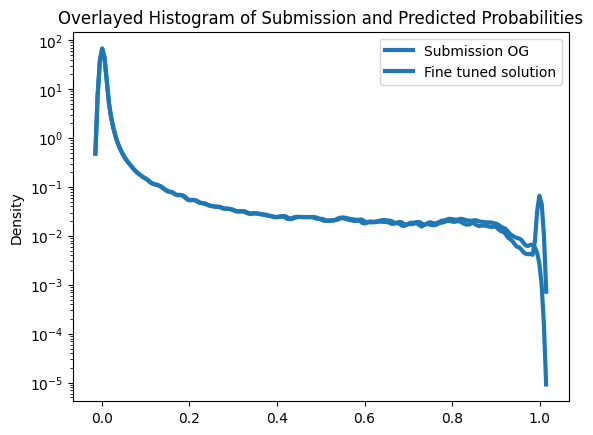

In [ ]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission OG', lw=3, alpha=1, color='r')
# sns.kdeplot(training_data['LOGISTIC_REG'], label='PredictionOG', lw=3, alpha=1)
sns.kdeplot(ensemble_submission, label='Fine tuned solution', lw=3, alpha=1, color='g')
# sns.kdeplot(submission_exp, label='Fine tuned solution per borrower', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()